In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX

from fbprophet import Prophet

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model

from tqdm import tqdm_notebook

In [2]:
def step_split(x_sequence, y_sequence, n_steps, n_features, n_forwards, n_predict_steps, test_set=False):
  x_sequence = np.array(x_sequence).reshape(-1, n_features)
  y_sequence = np.array(y_sequence).reshape(-1, 1)

  X, y = list(), list()
  if test_set:
    X = x_sequence[-n_steps:]
    X = np.array(X)
    X = X.reshape(1, n_steps, n_features)
  else:
    end = len(x_sequence) - n_steps - n_forwards - n_predict_steps + 2
    for i in range(end):
      seq_x = x_sequence[i:i+n_steps]
      seq_y = y_sequence[i+n_steps+n_forwards-1:i+n_steps+n_forwards+n_predict_steps-1]
      X.append(seq_x)
      y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], n_steps, n_features)
    y = y.reshape(y.shape[0], n_predict_steps)

  return X, y


def create_model(stateful,batch_size, n_steps, n_features):
    model = Sequential()
    model.add(LSTM(32,
                batch_input_shape=(batch_size, n_steps, n_features),
                stateful=stateful))
    model.add(Dense(1))
    optimizer = Adam()
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [3]:
df = pd.read_csv('Gold1.csv')

df = df.sort_values(by = 'datetime')
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y/%m/%d")

df.index = df['datetime']

df = df.drop('datetime', axis = 1)

df = df['Gold_Price']



df.columns = ['Gold_Price']

df = pd.DataFrame(df)

gold_df = df

In [8]:
# 2000년 부터의 데이터만 사용
X = gold_df[gold_df.index >= datetime.datetime(2000,1,1)]
y = gold_df[gold_df.index >= datetime.datetime(2000,1,1)]
#LSTM의 학습과 예측 기간 설정
n_steps = 32
training_period = 512 + n_steps
n_features = 1
n_forwards = 1
n_predict_steps = 1

#테스트 기간 설정
end = len(X) - n_steps - training_period
validation_size = 1200
start = end - validation_size

#예측 결과를 담을 리스트 만들기

yhat_prophet_list = list()
yhat_logistic_prophet_list = list()
y_real_list = list()
predict_index_list = list()

In [9]:
for i in tqdm_notebook(range(start, end)):
  data = X[i:i+training_period+n_steps]
  y_real = X.values[i+training_period+n_steps].item()
  y_real_list.append(y_real)
  predict_index = X.index[i+training_period+n_steps].date()
  predict_index_list.append(predict_index)
    #Prophet모델 정의와 학습
  prophet_model = Prophet(daily_seasonality = False)
  prophet_series = pd.DataFrame([data.index, data['Gold_Price']]).T
  prophet_series.columns = ['ds','y']
  prophet_model.fit(prophet_series)
  future =  prophet_model.make_future_dataframe(periods=1)
  prophet_forecast = prophet_model.predict(future[-1:])['yhat'].item()
  yhat_prophet_list.append(prophet_forecast)  

  0%|          | 0/1200 [00:00<?, ?it/s]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [10]:
for i in tqdm_notebook(range(start, end)):
  data = X[i:i+training_period+n_steps]

  prophet_series = pd.DataFrame([data.index, data['Gold_Price']]).T
  prophet_series.columns = ['ds','y']
  prophet_model = Prophet(growth = 'logistic', daily_seasonality = False)
  prophet_series['cap'] = prophet_series['y'].shift() * 1.1
  prophet_series['floor'] = prophet_series['y'].shift() * 0.9
  prophet_series.fillna(method='bfill', inplace=True)

  prophet_model.fit(prophet_series)
  future =  prophet_model.make_future_dataframe(periods=1)
  future['cap'] = prophet_series['cap'].append(pd.Series(prophet_series['y'].values[-1]*1.1),ignore_index=True)
  future['floor'] = prophet_series['floor'].append(pd.Series(prophet_series['y'].values[-1]*0.9),ignore_index=True)
  future.fillna(method='bfill', inplace=True)


  prophet_forecast = prophet_model.predict(future[-1:])['yhat'].item()
  yhat_logistic_prophet_list.append(prophet_forecast)  

  0%|          | 0/1200 [00:00<?, ?it/s]

In [12]:
len(yhat_prophet_list)

1200

In [13]:
len(yhat_logistic_prophet_list)

1200

In [14]:
result_df = pd.DataFrame(list(zip(y_real_list,yhat_prophet_list,yhat_logistic_prophet_list)),columns=['y','prophet','prophet_logistic'],index=predict_index_list)
col_list = ['prophet','prophet_logistic']
for col in col_list:
  mse = mean_squared_error(result_df['y'], result_df[col])
  print(f'{col} error: {mse}')

prophet error: 1298.7519447702728
prophet_logistic error: 1273.2133713430826


In [15]:
result_df

,y,prophet,prophet_logistic
2016-10-13,1312.30,1363.874137,1302.306843
2016-10-14,1310.40,1366.150278,1314.465186
2016-10-17,1311.80,1404.313456,1388.992472
2016-10-18,1318.60,1357.494267,1317.442534
2016-10-19,1325.20,1356.923470,1318.214793
...,...,...,...
2021-04-21,1792.30,1734.881544,1773.179453
2021-04-22,1781.20,1736.911795,1791.499199
2021-04-23,1777.00,1737.134914,1776.917092
2021-04-25,1774.65,1686.647183,1782.034113


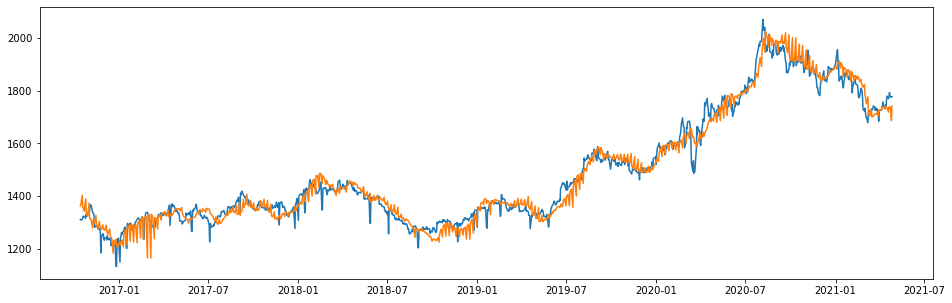

In [17]:
# 1990년 이후 금 시세 + 평균
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(result_df['y'])
plt.plot(result_df['prophet'])
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(result_df['y'], result_df['prophet'])**0.5
print(RMSE)

36.038201186661254


In [19]:
from sklearn.metrics import r2_score
print(r2_score(result_df['y'],result_df['prophet']))

0.971362303236309


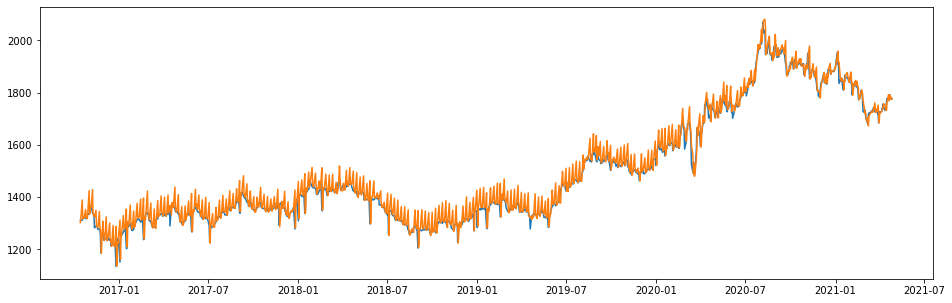

In [18]:
# 1990년 이후 금 시세 + 평균
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(result_df['y'])
plt.plot(result_df['prophet_logistic'])
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(result_df['y'], result_df['prophet_logistic'])**0.5
print(RMSE)

35.68211556708882


In [20]:
from sklearn.metrics import r2_score
print(r2_score(result_df['y'],result_df['prophet_logistic']))

0.9719254330352904


In [39]:
future =  prophet_model.make_future_dataframe(periods=30)

In [66]:
future = future[575:]

In [67]:
future['floor'] = 1000
future['cap'] = 2500

In [68]:
forecast = prophet_model.predict(future)

In [69]:
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-04-25,1740.828464,2500,1000,1700.508173,1748.078136,1740.828464,1740.828464,-16.502435,-16.502435,...,-15.359427,-15.359427,-15.359427,-1.143009,-1.143009,-1.143009,0.0,0.0,0.0,1724.326028
1,2021-04-26,1740.816947,2500,1000,1719.191925,1766.744880,1740.816947,1740.816947,2.958754,2.958754,...,3.995802,3.995802,3.995802,-1.037047,-1.037047,-1.037047,0.0,0.0,0.0,1743.775702
2,2021-04-27,1740.805431,2500,1000,1718.985629,1770.363935,1740.805431,1740.805431,3.326222,3.326222,...,4.218909,4.218909,4.218909,-0.892688,-0.892688,-0.892688,0.0,0.0,0.0,1744.131653
3,2021-04-28,1740.793915,2500,1000,1717.566013,1764.602423,1740.793915,1740.793915,-0.705277,-0.705277,...,0.010897,0.010897,0.010897,-0.716174,-0.716174,-0.716174,0.0,0.0,0.0,1740.088638
4,2021-04-29,1740.782399,2500,1000,1718.055031,1766.843855,1740.782399,1740.782399,1.823556,1.823556,...,2.338108,2.338108,2.338108,-0.514552,-0.514552,-0.514552,0.0,0.0,0.0,1742.605955
5,2021-04-30,1740.770882,2500,1000,1714.740594,1764.309808,1740.770882,1740.770882,-0.106698,-0.106698,...,0.188764,0.188764,0.188764,-0.295462,-0.295462,-0.295462,0.0,0.0,0.0,1740.664184
6,2021-05-01,1740.759366,2500,1000,1718.503394,1769.953774,1740.759366,1740.759366,4.540031,4.540031,...,4.606947,4.606947,4.606947,-0.066915,-0.066915,-0.066915,0.0,0.0,0.0,1745.299398
7,2021-05-02,1740.747850,2500,1000,1700.686116,1749.761974,1740.747850,1740.747850,-15.196486,-15.196486,...,-15.359427,-15.359427,-15.359427,0.162941,0.162941,0.162941,0.0,0.0,0.0,1725.551364
8,2021-05-03,1740.736334,2500,1000,1719.942990,1768.948316,1740.736334,1740.736334,4.381861,4.381861,...,3.995802,3.995802,3.995802,0.386059,0.386059,0.386059,0.0,0.0,0.0,1745.118195
9,2021-05-04,1740.724818,2500,1000,1721.258831,1768.452444,1740.724818,1740.724818,4.813639,4.813639,...,4.218909,4.218909,4.218909,0.594729,0.594729,0.594729,0.0,0.0,0.0,1745.538456


In [70]:
forecast.index = forecast['ds']

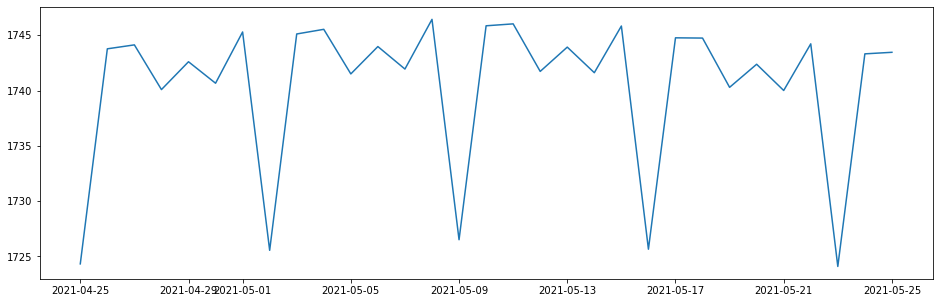

In [72]:
# 1990년 이후 금 시세 + 평균
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(forecast['yhat'])

plt.show()